<h1> DOGECOIN SENTIMENT ANALYSIS</h1>

# Installation, imports, datareading, functions

### Installs

In [3]:
!pip install wordcloud matplotlib
!pip install vaderSentiment
!pip install yfinance
!pip install livelossplot

     |████████████████████████████████| 133kB 12.6MB/s 
     |████████████████████████████████| 6.3MB 14.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=a8b4e4a83ce595ee7297f228fa7cf83f909aa74cec39e8ae8649587f8087e344
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


###Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway
from scipy.stats import sem
import matplotlib.ticker as mtick
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydot
import wordcloud as wc
from pandas_datareader import data as wb
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data
import re
import string
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

import yfinance as yf

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from livelossplot import PlotLossesKeras

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Functions

In [7]:
def preprocess_post_text(post):
  #Lowercase
  post = post.lower()

  #Remove urls
  post = re.sub(r"https\S+|www\S+|https\S+","",post, flags=re.MULTILINE)

  #Punctuation
  post = post.translate(str.maketrans("","", string.punctuation))

  #remove html tags and weird text
  post = re.sub(r"\@\w+|\#", "",post)

  #remove stopwords
  post_tokens = word_tokenize(post)
  filtered_words = [word for word in post_tokens if word not in stop_words]

  #Stemming
  ps = PorterStemmer()
  stemmed_words = [ps.stem(w) for w in filtered_words]

  #Lemmatizing
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w,pos='a') for w in stemmed_words]

  return " ".join(lemma_words)

preprocess_post_text("Hi there, how are you preparing for your exams?")

'hi prepar exam'

In [8]:
def getSentiment(x):
  """
    Takes a polarity value or compound SIA and discretizes it
    1->bad; 
    2->neutral;
    3->good
  """
  if x<-0.2:
    return 1
  if x>0.2:
    return 3
  else:
    return 2

In [9]:
def getMonth(x):
  date = datetime.fromtimestamp(x)
  return date.month
def getDay(x):
  date = datetime.fromtimestamp(x)
  return date.day
def getHour(x):
  date = datetime.fromtimestamp(x)
  return date.hour

### Dataframes

Top N posts each hour from the Dogecoin Subreddit 

In [10]:
reddit_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reddit.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (9,10,68,69,72,73,74,75,76,79,80,82,84,85,88,89,90,91,92,95,96,98,99,101,103,105,107,109,112,113,114,115,116,119,120,121,122,123,124,127,128,129,130,131,132,133,134,137,138,139,140,141,142,145,150,151,152,153,154,157,158,159,160,161,162,165,168,170,172,173,174,175,178,180,182,183,184,185,188,189,190,191,192,193,196,197,198,199,200,201,204,205,206,207,208,209,212,213,214,215,216,217,220,221,222,223,224,225,226,229,230,231,232,233,234,237,238,239,240,241,242,245,246,247,248,249,250,253,254,255,256,257,258,261,262,263,264,265,266,269,270,271,272,273,274,277,278,279,280,281,282,285,286,287,288,289,290,293,294,295,296,297,298,301,302,303,304,305,306,309,310,311,312,313,314,317,318,319,320,321,322,325,326,327,328,329,330,333,334,335,336,337,338,341,342,343,344,345,346,349,350,351,352,353,354,355,358,359,360,361,362,363,366,367,368,369,370,371,374,375,376,377,378,379,382,383,384,385,386,387,39

Hourly price of Dogecoin from Yahoo Finance

In [11]:
doge_price_df = yf.download(tickers="DOGE-USD", period="70d", interval="1h").reset_index()
try:
  doge_price_df = doge_price_df.rename(columns={'index':'Datetime'})
except:
  pass
doge_price_df

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2021-02-26 00:00:00+00:00,0.050138,0.051130,0.049150,0.049384,0.049384,0
1,2021-02-26 01:00:00+00:00,0.049511,0.051378,0.049511,0.050103,0.050103,0
2,2021-02-26 02:00:00+00:00,0.050125,0.051169,0.050075,0.050942,0.050942,10003456
3,2021-02-26 03:00:00+00:00,0.050940,0.051518,0.050739,0.051402,0.051402,0
4,2021-02-26 04:00:00+00:00,0.051394,0.051609,0.050494,0.050513,0.050513,0
...,...,...,...,...,...,...,...
1672,2021-05-06 17:00:00+01:00,0.599437,0.607057,0.591497,0.606018,0.606018,0
1673,2021-05-06 18:00:00+01:00,0.609293,0.609293,0.583940,0.583940,0.583940,71860224
1674,2021-05-06 19:00:00+01:00,0.579240,0.588302,0.545102,0.580120,0.580120,2074458112
1675,2021-05-06 20:00:00+01:00,0.582719,0.585371,0.562928,0.577224,0.577224,813199360


# Preprocessing

## Reddit DF

In [12]:
reddit_df.head(10)

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_css_class,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,...,media_metadata.3mdwgezlslw61.e,media_metadata.3mdwgezlslw61.id,media_metadata.3mdwgezlslw61.m,media_metadata.3mdwgezlslw61.p,media_metadata.3mdwgezlslw61.s.u,media_metadata.3mdwgezlslw61.s.x,media_metadata.3mdwgezlslw61.s.y,media_metadata.3mdwgezlslw61.status,media_metadata.09xq8ymbtpw61.e,media_metadata.09xq8ymbtpw61.id,media_metadata.09xq8ymbtpw61.m,media_metadata.09xq8ymbtpw61.p,media_metadata.09xq8ymbtpw61.s.u,media_metadata.09xq8ymbtpw61.s.x,media_metadata.09xq8ymbtpw61.s.y,media_metadata.09xq8ymbtpw61.status,media_metadata.6gslu4yuizw61.e,media_metadata.6gslu4yuizw61.id,media_metadata.6gslu4yuizw61.m,media_metadata.6gslu4yuizw61.p,media_metadata.6gslu4yuizw61.s.u,media_metadata.6gslu4yuizw61.s.x,media_metadata.6gslu4yuizw61.s.y,media_metadata.6gslu4yuizw61.status,media_metadata.1t2e32kfg5x61.e,media_metadata.1t2e32kfg5x61.id,media_metadata.1t2e32kfg5x61.m,media_metadata.1t2e32kfg5x61.p,media_metadata.1t2e32kfg5x61.s.u,media_metadata.1t2e32kfg5x61.s.x,media_metadata.1t2e32kfg5x61.s.y,media_metadata.1t2e32kfg5x61.status,media_metadata.269o02kfg5x61.e,media_metadata.269o02kfg5x61.id,media_metadata.269o02kfg5x61.m,media_metadata.269o02kfg5x61.p,media_metadata.269o02kfg5x61.s.u,media_metadata.269o02kfg5x61.s.x,media_metadata.269o02kfg5x61.s.y,media_metadata.269o02kfg5x61.status
0,0,[],False,ICEINTHENICE,NaN,[],NaN,text,t2_6g9oysom,False,False,[],False,False,1614721359,i.redd.it,https://www.reddit.com/r/dogecoin/comments/lwd...,lwdayg,True,False,False,True,True,False,False,NaN,meme,"[{'e': 'text', 't': 'Meme'}]",87bff62c-7cd0-11e7-a355-0e4bf47170fe,Meme,dark,richtext,False,False,False,2,0,False,all_ads,/r/dogecoin/comments/lwdayg/for_the_dogecoin_h...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,OmanyteOmelette,shibe,"[{'e': 'text', 't': 'Ð 🚀🌙'}]",Ð 🚀🌙,richtext,t2_6l49x2bk,False,False,[],False,False,1614729244,i.redd.it,https://www.reddit.com/r/dogecoin/comments/lwg...,lwg1oh,True,False,False,True,True,False,False,NaN,NaN,[],NaN,NaN,dark,text,False,False,False,0,0,False,all_ads,/r/dogecoin/comments/lwg1oh/to_the_moon/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,bassiebitcoin,NaN,[],NaN,text,t2_a3oo6z9g,False,False,[],False,False,1614726572,twitter.com,https://www.reddit.com/r/dogecoin/comments/lwf...,lwf5yn,True,False,False,False,True,False,False,NaN,give,"[{'e': 'text', 't': 'Competition'}]",6f03166e-7cd0-11e7-a18b-0ef1cdbd8f7c,Competition,dark,richtext,False,False,False,1,0,False,all_ads,/r/dogecoin/comments/lwf5yn/go_doge_much_speed...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,popcity_peep,NaN,[],NaN,text,t2_40la3odv,False,True,[],False,False,1614700662,i.redd.it,https://www.reddit.com/r/dogecoin/comments/lw5...,lw597u,True,False,False,True,True,False,False,NaN,meme,"[{'e': 'text', 't': 'Meme'}]",87bff62c-7cd0-11e7-a355-0e4bf47170fe,Meme,dark,richtext,False,False,False,2,0,False,all_ads,/r/dogecoin/comments/lw597u/i_want_them_all/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Cleaning

Keep only important columns

In [13]:
drop_cols = []
for val in reddit_df.columns.values:
  if "meta" not in val and "media" not in val and '.' not in val:
    print(val)
    
reddit_df = reddit_df.drop(drop_cols, axis=1)

Unnamed: 0
all_awardings
allow_live_comments
author
author_flair_css_class
author_flair_richtext
author_flair_text
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
can_mod_post
contest_mode
created_utc
domain
full_link
id
is_crosspostable
is_original_content
is_robot_indexable
is_self
is_video
link_flair_background_color
link_flair_css_class
link_flair_richtext
link_flair_template_id
link_flair_text
link_flair_text_color
link_flair_type
locked
no_follow
num_comments
num_crossposts
over_18
parent_whitelist_status
permalink
pinned
post_hint
pwls
retrieved_on
score
selftext
send_replies
spoiler
stickied
subreddit
subreddit_id
subreddit_subscribers
subreddit_type
thumbnail
thumbnail_height
thumbnail_width
title
total_awards_received
treatment_tags
upvote_ratio
url
url_overridden_by_dest
whitelist_status
wls
author_flair_template_id
author_flair_text_color
removed_by_category
is_gallery
crosspost_parent
crosspost_parent_list
gilded
edited
author_flair_backgroun

In [14]:
reddit_df = reddit_df[['author','author_premium','created_utc','domain','num_comments','post_hint','score','selftext','title','total_awards_received','upvote_ratio','edited']]
reddit_df

,author,author_premium,created_utc,domain,num_comments,post_hint,score,selftext,title,total_awards_received,upvote_ratio,edited
0,ICEINTHENICE,False,1614721359,i.redd.it,2,image,2,NaN,FOR THE DOGECOIN HATERS IN HERE,0,1.00,NaN
1,OmanyteOmelette,False,1614729244,i.redd.it,0,image,2,NaN,To the Moon!!,0,1.00,NaN
2,bassiebitcoin,False,1614726572,twitter.com,1,link,2,NaN,Go doge ! Much speed wow,0,1.00,NaN
3,popcity_peep,True,1614700662,i.redd.it,2,image,2,NaN,I want them all!!,0,1.00,NaN
4,chappaeye,False,1614723779,i.redd.it,2,image,2,NaN,Me watching doge get pillaged by daytraders.,0,1.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,kewtyp,False,1620154331,i.redd.it,0,image,14,NaN,The struggle is real...,0,0.93,NaN
4996,Thedogeguy5444,False,1620154160,i.redd.it,1,image,14,NaN,#DOGETHEFUTURE,1,1.00,NaN
4997,Prettyfeet_Bellaxoxo,False,1620155075,i.redd.it,0,image,14,NaN,I'm so sick over this they I made my first mem...,0,0.94,NaN
4998,kewtyp,False,1620156681,i.redd.it,0,image,14,NaN,Dogecoin after it went up 10x in Feb...,0,1.00,NaN


Drop duplicates

In [15]:
bf = len(reddit_df)
reddit_df = reddit_df.drop_duplicates()
print(f'{bf - len(reddit_df)} values dropped')

0 values dropped


### Familiarization

In [16]:
print(f"{len(reddit_df)} posts")

5000 posts


In [17]:
print(f"{len(reddit_df['author'].unique())} unique authors")

3727 unique authors


In [18]:
print(f"{len(reddit_df[~reddit_df['selftext'].isna()])} posts with text")

1202 posts with text


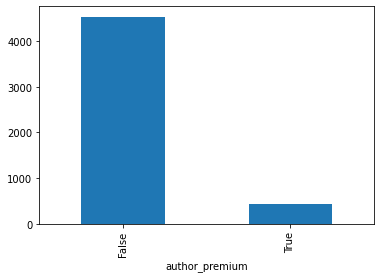

In [19]:
reddit_df.groupby(['author_premium']).count()['created_utc'].plot(kind='bar')
plt.show()

In [20]:
g = reddit_df.copy()
g['edited'] = reddit_df['edited'].apply(lambda x: 1 if x>0 else 0)
print(f"{g.groupby(['edited']).count()['created_utc'].values[1]} posts edited")
print(f"{g.groupby(['edited']).count()['created_utc'].values[0]} posts unedited")

14 posts edited
4986 posts unedited


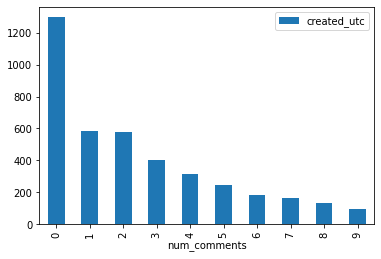

In [21]:
g = reddit_df.groupby(['num_comments']).count()[['created_utc']]
g[g.index<10].plot(kind='bar')
plt.show()

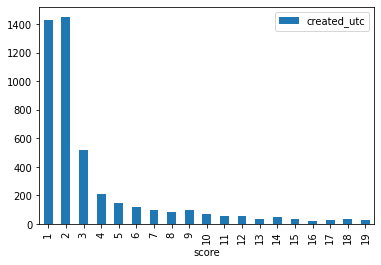

In [22]:
g = reddit_df.groupby(['score']).count()[['created_utc']]
g[g.index<20].plot(kind='bar')
plt.show()

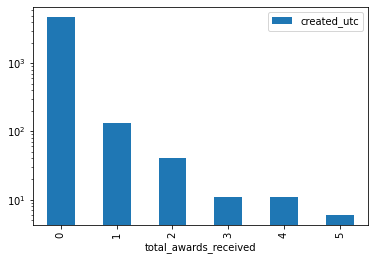

In [23]:
g = reddit_df.groupby(['total_awards_received']).count()[['created_utc']]
g[g.index<6].plot(kind='bar',logy=True)
plt.show()

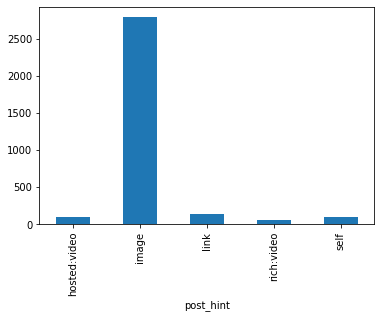

In [24]:
reddit_df.groupby(['post_hint']).count()['created_utc'].plot(kind='bar')
plt.show()

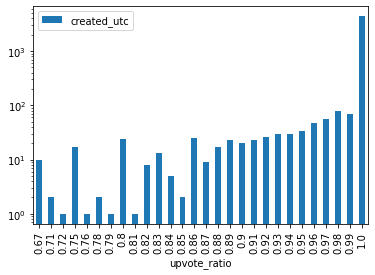

In [25]:
g = reddit_df.groupby(['upvote_ratio']).count()[['created_utc']]
g.plot(kind='bar',logy=True)
plt.show()


### Preprocessing

Replace emojis with text

In [26]:
reddit_df['title'] = reddit_df['title'].apply(lambda x: x.replace('🚀','rocket_emoji ').replace('🌑','moon_emoji ').replace('💎','diamond_emoji ').replace('🙌','hands_emoji '))

Separate timestamp

In [27]:
reddit_df['timestamp'] =reddit_df['created_utc'] 
reddit_df['month'] = reddit_df['timestamp'].apply(getMonth)
reddit_df['day'] = reddit_df['timestamp'].apply(getDay)
reddit_df['hour'] = reddit_df['timestamp'].apply(getHour)
reddit_df = reddit_df.drop('timestamp',axis=1)

##DOGE Price DF

In [28]:
fig = go.Figure(data=[go.Candlestick(x=doge_price_df['Datetime'],
                open=doge_price_df['Open'],
                high=doge_price_df['High'],
                low=doge_price_df['Low'],
                close=doge_price_df['Close'])])

fig.show()

Separate Month, Day, Hour

In [29]:
doge_price_df['month']= doge_price_df['Datetime'].apply(lambda x: x.month)
doge_price_df['day'] = doge_price_df['Datetime'].apply(lambda x: x.day)
doge_price_df['hour'] = doge_price_df['Datetime'].apply(lambda x: x.hour)

# Processing

In [70]:
processed_df= reddit_df.copy()

Take the same time frame for both dataframes

In [71]:
reddit_min_time = reddit_df.sort_values('created_utc').head(1)[['month','day','hour']].values[0]
min_datetime = datetime(datetime.now().year, reddit_min_time[0],reddit_min_time[1],reddit_min_time[2])

reddit_max_time = reddit_df.sort_values('created_utc',ascending=False).head(1)[['month','day','hour']].values[0]
max_datetime = datetime(datetime.now().year, reddit_max_time[0],reddit_max_time[1],reddit_max_time[2])

In [72]:
doge_price_df['Datetime'] = doge_price_df['Datetime'].apply(lambda x:datetime.fromtimestamp(x.timestamp()) )
doge_price_df = doge_price_df[(doge_price_df['Datetime'] >= min_datetime) & ((doge_price_df['Datetime'] <= max_datetime))].copy()

Encode columns

In [73]:
categorical_cols = [
                    'domain',
                    'post_hint'
]
binary_cols= [
              'author_premium',
]
ordinal_cols=[
              'num_comments',
              'score',
              'total_awards_received'
]

In [74]:
for col in categorical_cols:
  processed_df[col] = processed_df[col].factorize()[0]

for col in binary_cols:
  processed_df[col] = processed_df[col].apply(lambda x: 0 if x == 'False' else 1)

processed_df = processed_df.drop('author',axis=1)

processed_df['selftext']=processed_df['selftext'].fillna('')

processed_df['edited']=processed_df['edited'].apply(lambda x: 1 if x>0 else 0)

processed_df

,author_premium,created_utc,domain,num_comments,post_hint,score,selftext,title,total_awards_received,upvote_ratio,edited,month,day,hour
0,1,1614721359,0,2,0,2,,FOR THE DOGECOIN HATERS IN HERE,0,1.00,0,3,2,21
1,1,1614729244,0,0,0,2,,To the Moon!!,0,1.00,0,3,2,23
2,1,1614726572,1,1,1,2,,Go doge ! Much speed wow,0,1.00,0,3,2,23
3,1,1614700662,0,2,0,2,,I want them all!!,0,1.00,0,3,2,15
4,1,1614723779,0,2,0,2,,Me watching doge get pillaged by daytraders.,0,1.00,0,3,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1620154331,0,0,0,14,,The struggle is real...,0,0.93,0,5,4,18
4996,1,1620154160,0,1,0,14,,#DOGETHEFUTURE,1,1.00,0,5,4,18
4997,1,1620155075,0,0,0,14,,I'm so sick over this they I made my first mem...,0,0.94,0,5,4,19
4998,1,1620156681,0,0,0,14,,Dogecoin after it went up 10x in Feb...,0,1.00,0,5,4,19


In [75]:
buy_words=[
           'moon',
           'to the moon',
           'buy',
           'speed',
           'wow',
           'up',
           'rocket_emoji',
           'moon_emoji',
           'buying',
           'bought',
]
hold_words = [
              'hodl',
              'hold',
              'diamond_emoji',
              'hands_emoji',
              'not sell'

]
sell_words=[
            'sell',
            'fuck',
            'over',
            'whale'
]

def countWords(x,action_words):
  word_list = x.lower().replace('.', '').split(' ')
  word_count = 0
  for word in word_list:
    if word in action_words:
      word_count +=1
  return word_count


processed_df['buy_count'] = processed_df['title'].apply(lambda x: countWords(x,buy_words))
processed_df['hold_count'] = processed_df['title'].apply(lambda x: countWords(x,hold_words))
processed_df['sell_count'] = processed_df['title'].apply(lambda x: countWords(x,sell_words))
processed_df['buy_count'] = processed_df['buy_count'] / (processed_df['buy_count'] + processed_df['hold_count'] + processed_df['sell_count'])
processed_df['hold_count'] = processed_df['hold_count'] / (processed_df['buy_count'] + processed_df['hold_count'] + processed_df['sell_count'])
processed_df['sell_count'] = processed_df['sell_count'] / (processed_df['buy_count'] + processed_df['hold_count'] + processed_df['sell_count'])

processed_df['selftext_buy_count'] = processed_df['selftext'].apply(lambda x: countWords(x,buy_words))
processed_df['selftext_hold_count'] = processed_df['selftext'].apply(lambda x: countWords(x,hold_words))
processed_df['selftext_sell_count'] = processed_df['selftext'].apply(lambda x: countWords(x,sell_words))
processed_df['selftext_buy_count'] = processed_df['selftext_buy_count'] / (processed_df['selftext_buy_count'] + processed_df['selftext_hold_count'] + processed_df['selftext_sell_count'])
processed_df['selftext_hold_count'] = processed_df['selftext_hold_count'] / (processed_df['selftext_buy_count'] + processed_df['selftext_hold_count'] + processed_df['selftext_sell_count'])
processed_df['selftext_sell_count'] = processed_df['selftext_sell_count'] / (processed_df['selftext_buy_count'] + processed_df['selftext_hold_count'] + processed_df['selftext_sell_count'])

processed_df['buy_count']=processed_df['buy_count'].fillna(0)
processed_df['hold_count']=processed_df['hold_count'].fillna(0)
processed_df['sell_count']=processed_df['sell_count'].fillna(0)
processed_df['selftext_buy_count']=processed_df['selftext_buy_count'].fillna(0)
processed_df['selftext_hold_count']=processed_df['selftext_hold_count'].fillna(0)
processed_df['selftext_sell_count']=processed_df['selftext_sell_count'].fillna(0)

In [76]:
print(len(processed_df[processed_df['buy_count']!=0]))
print(len(processed_df[processed_df['hold_count']!=0]))
print(len(processed_df[processed_df['sell_count']!=0]))

1078
365
81


## Titles

Apply sentiment analysis on titles

In [77]:
processed_df['title_processed'] = processed_df['title'].apply(preprocess_post_text)

processed_df['polarity'] = processed_df['title_processed'].apply(lambda x: TextBlob(x).sentiment.polarity )
processed_df['subjectivity'] = processed_df['title_processed'].apply(lambda x: TextBlob(x).sentiment.subjectivity )
processed_df['SIA_neg'] = processed_df['title_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
processed_df['SIA_neu'] = processed_df['title_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neu'])
processed_df['SIA_pos']  = processed_df['title_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
processed_df['SIA_compound'] = processed_df['title_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])

In [78]:
processed_df

,author_premium,created_utc,domain,num_comments,post_hint,score,selftext,title,total_awards_received,upvote_ratio,edited,month,day,hour,buy_count,hold_count,sell_count,selftext_buy_count,selftext_hold_count,selftext_sell_count,title_processed,polarity,subjectivity,SIA_neg,SIA_neu,SIA_pos,SIA_compound
0,1,1614721359,0,2,0,2,,FOR THE DOGECOIN HATERS IN HERE,0,1.00,0,3,2,21,0.0,0.0,0.0,0.0,0.0,0.0,dogecoin hater,0.000000,0.000000,0.737,0.263,0.000,-0.4215
1,1,1614729244,0,0,0,2,,To the Moon!!,0,1.00,0,3,2,23,0.0,0.0,0.0,0.0,0.0,0.0,moon,0.000000,0.000000,0.000,1.000,0.000,0.0000
2,1,1614726572,1,1,1,2,,Go doge ! Much speed wow,0,1.00,0,3,2,23,1.0,0.0,0.0,0.0,0.0,0.0,go doge much speed wow,0.150000,0.600000,0.000,0.513,0.487,0.5859
3,1,1614700662,0,2,0,2,,I want them all!!,0,1.00,0,3,2,15,0.0,0.0,0.0,0.0,0.0,0.0,want,0.000000,0.000000,0.000,0.000,1.000,0.0772
4,1,1614723779,0,2,0,2,,Me watching doge get pillaged by daytraders.,0,1.00,0,3,2,22,0.0,0.0,0.0,0.0,0.0,0.0,watch doge get pillag daytrad,0.000000,0.000000,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1620154331,0,0,0,14,,The struggle is real...,0,0.93,0,5,4,18,0.0,0.0,0.0,0.0,0.0,0.0,struggl real,0.200000,0.300000,0.000,1.000,0.000,0.0000
4996,1,1620154160,0,1,0,14,,#DOGETHEFUTURE,1,1.00,0,5,4,18,0.0,0.0,0.0,0.0,0.0,0.0,dogethefutur,0.000000,0.000000,0.000,1.000,0.000,0.0000
4997,1,1620155075,0,0,0,14,,I'm so sick over this they I made my first mem...,0,0.94,0,5,4,19,0.0,0.0,1.0,0.0,0.0,0.0,im sick made first meme😭😭😭,-0.232143,0.595238,0.558,0.442,0.000,-0.9118
4998,1,1620156681,0,0,0,14,,Dogecoin after it went up 10x in Feb...,0,1.00,0,5,4,19,1.0,0.0,0.0,0.0,0.0,0.0,dogecoin went 10x feb,0.000000,0.000000,0.000,1.000,0.000,0.0000


Discretized feelings

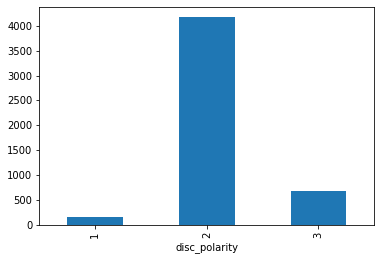

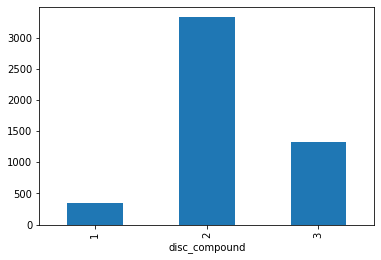

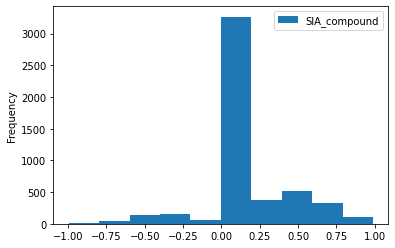

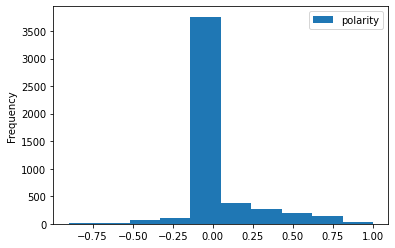

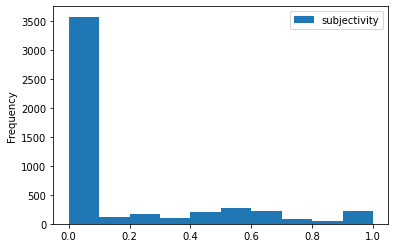

In [79]:
g = processed_df.copy()
g['disc_polarity'] = processed_df['polarity'].apply(getSentiment)
g['disc_compound'] = processed_df['SIA_compound'].apply(getSentiment)

g.groupby('disc_polarity').count()['created_utc'].plot(kind='bar')
plt.show()

g.groupby('disc_compound').count()['created_utc'].plot(kind='bar')
plt.show()

processed_df.plot.hist(y='SIA_compound')
plt.show()

processed_df.plot.hist(y='polarity')
plt.show()

processed_df.plot.hist(y='subjectivity')
plt.show()

Original Title WordCloud

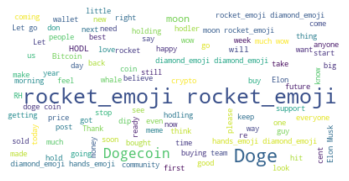

dict_keys(['rocket_emoji rocket_emoji', 'Doge', 'Dogecoin', 'moon', 'HODL', 'will', 'now', 'day', 'go', 'new', 'Let', 'good', 'much', 'crypto', 'coin', 'time', 'going', 'love', 'see', 'us', 'buy', 'today', 'diamond_emoji diamond_emoji', 'one', 'guy', 'got', 'cent', 'know', 'hold', 'moon rocket_emoji', 'back', 'keep', 'dip', 'need', 'take', 'people', 'bought', 'hit', 'make', 'first', 'Elon', 'holding', 'think', 'community', 'say', 'way', 'Thank', 'buying', 'still', 'diamond_emoji hands_emoji', 'rocket_emoji diamond_emoji', 'price', 'next', 'year', 'meme', 'everyone', 'Elon Musk', 'hodler', 'want', 'made', 'stop', 'coming', 'come', 'best', 'thing', 'hodling', 'Bitcoin', 'ready', 'doge coin', 'future', 'wallet', 'big', 'look', 'wow', 're', 'week', 'RH', 'money', 'right', 'post', 'whale', 'don', 'happy', 'hands_emoji diamond_emoji', 'anyone', 'feel', 'sold', 'please', 'rocket', 'support', 'much wow', 'Let go', 'even', 'team', 'start', 'little', 'believe', 'getting', 'morning', 'soon'])


In [80]:
text = ''.join(processed_df.title.fillna(''))

wordcloud = wc.WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

Processed Title WordCloud

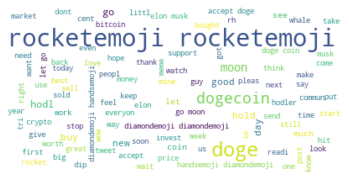

dict_keys(['rocketemoji rocketemoji', 'doge', 'dogecoin', 'moon', 'go', 'hodl', 'hold', 'buy', 'new', 'good', 'day', 'let', 'see', 'much', 'coin', 'crypto', 'diamondemoji diamondemoji', 'time', 'make', 'us', 'take', 'cent', 'hit', 'know', 'keep', 'back', 'guy', 'today', 'love', 'need', 'look', 'say', 'come', 'one', 'first', 'price', 'dip', 'start', 'got', 'elon', 'everyon', 'still', 'commun', 'im', 'next', 'use', 'big', 'think', 'peopl', 'way', 'meme', 'post', 'hodler', 'bitcoin', 'thank', 'work', 'bought', 'diamondemoji handsemoji', 'want', 'hope', 'accept', 'readi', 'accept doge', 'invest', 'sell', 'put', 'support', 'wait', 'mine', 'right', 'week', 'stop', 'let go', 'rh', 'even', 'rocket', 'watch', 'worth', 'year', 'littl', 'go moon', 'dont', 'tweet', 'market', 'wow', 'whale', 'musk', 'money', 'elon musk', 'handsemoji diamondemoji', 'feel', 'tri', 'give', 'sold', 'pleas', 'best', 'soon', 'send', 'doge coin', 'great'])


In [81]:
text = ''.join(processed_df.title_processed.fillna(''))

wordcloud = wc.WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

## Selftext

In [82]:
processed_df['selftext_processed'] = processed_df['selftext'].apply(preprocess_post_text)

processed_df['polarity_selftext'] = processed_df['selftext_processed'].apply(lambda x: TextBlob(x).sentiment.polarity)
processed_df['subjectivity_selftext'] = processed_df['selftext_processed'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
processed_df['SIA_neg_selftext'] = processed_df['selftext_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
processed_df['SIA_neu_selftext'] = processed_df['selftext_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neu'])
processed_df['SIA_pos_selftext'] = processed_df['selftext_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
processed_df['SIA_compound_selftext'] = processed_df['selftext_processed'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
processed_df

,author_premium,created_utc,domain,num_comments,post_hint,score,selftext,title,total_awards_received,upvote_ratio,edited,month,day,hour,buy_count,hold_count,sell_count,selftext_buy_count,selftext_hold_count,selftext_sell_count,title_processed,polarity,subjectivity,SIA_neg,SIA_neu,SIA_pos,SIA_compound,selftext_processed,polarity_selftext,subjectivity_selftext,SIA_neg_selftext,SIA_neu_selftext,SIA_pos_selftext,SIA_compound_selftext
0,1,1614721359,0,2,0,2,,FOR THE DOGECOIN HATERS IN HERE,0,1.00,0,3,2,21,0.0,0.0,0.0,0.0,0.0,0.0,dogecoin hater,0.000000,0.000000,0.737,0.263,0.000,-0.4215,,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1614729244,0,0,0,2,,To the Moon!!,0,1.00,0,3,2,23,0.0,0.0,0.0,0.0,0.0,0.0,moon,0.000000,0.000000,0.000,1.000,0.000,0.0000,,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1614726572,1,1,1,2,,Go doge ! Much speed wow,0,1.00,0,3,2,23,1.0,0.0,0.0,0.0,0.0,0.0,go doge much speed wow,0.150000,0.600000,0.000,0.513,0.487,0.5859,,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1614700662,0,2,0,2,,I want them all!!,0,1.00,0,3,2,15,0.0,0.0,0.0,0.0,0.0,0.0,want,0.000000,0.000000,0.000,0.000,1.000,0.0772,,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1614723779,0,2,0,2,,Me watching doge get pillaged by daytraders.,0,1.00,0,3,2,22,0.0,0.0,0.0,0.0,0.0,0.0,watch doge get pillag daytrad,0.000000,0.000000,0.000,1.000,0.000,0.0000,,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1620154331,0,0,0,14,,The struggle is real...,0,0.93,0,5,4,18,0.0,0.0,0.0,0.0,0.0,0.0,struggl real,0.200000,0.300000,0.000,1.000,0.000,0.0000,,0.0,0.0,0.0,0.0,0.0,0.0
4996,1,1620154160,0,1,0,14,,#DOGETHEFUTURE,1,1.00,0,5,4,18,0.0,0.0,0.0,0.0,0.0,0.0,dogethefutur,0.000000,0.000000,0.000,1.000,0.000,0.0000,,0.0,0.0,0.0,0.0,0.0,0.0
4997,1,1620155075,0,0,0,14,,I'm so sick over this they I made my first mem...,0,0.94,0,5,4,19,0.0,0.0,1.0,0.0,0.0,0.0,im sick made first meme😭😭😭,-0.232143,0.595238,0.558,0.442,0.000,-0.9118,,0.0,0.0,0.0,0.0,0.0,0.0
4998,1,1620156681,0,0,0,14,,Dogecoin after it went up 10x in Feb...,0,1.00,0,5,4,19,1.0,0.0,0.0,0.0,0.0,0.0,dogecoin went 10x feb,0.000000,0.000000,0.000,1.000,0.000,0.0000,,0.0,0.0,0.0,0.0,0.0,0.0


Discretized feelings

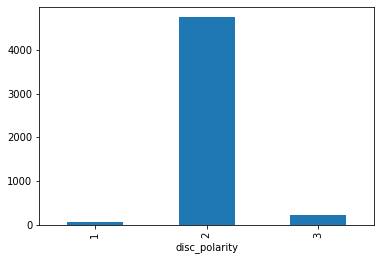

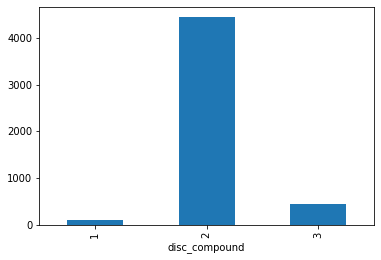

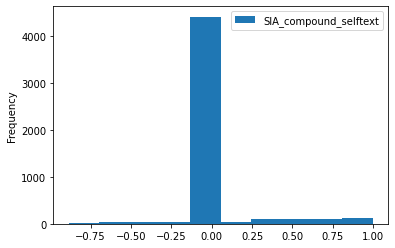

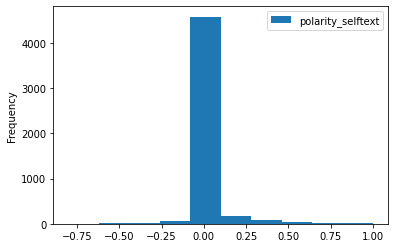

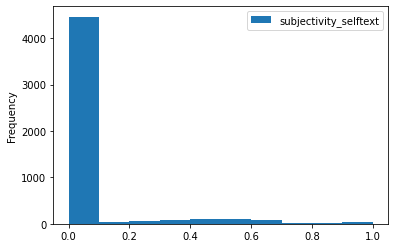

In [83]:
g = processed_df.copy()
g['disc_polarity'] = processed_df['polarity_selftext'].apply(getSentiment)
g['disc_compound'] = processed_df['SIA_compound_selftext'].apply(getSentiment)

g.groupby('disc_polarity').count()['created_utc'].plot(kind='bar')
plt.show()

g.groupby('disc_compound').count()['created_utc'].plot(kind='bar')
plt.show()

processed_df.plot.hist(y='SIA_compound_selftext')
plt.show()

processed_df.plot.hist(y='polarity_selftext')
plt.show()

processed_df.plot.hist(y='subjectivity_selftext')
plt.show()

Original Title WordCloud

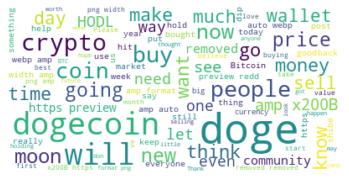

dict_keys(['doge', 'dogecoin', 'will', 'crypto', 'buy', 'people', 'coin', 'now', 'moon', 'going', 'new', 'price', 'time', 'make', 'go', 'want', 'know', 'think', 'money', 'sell', 'day', 'wallet', 'much', 'amp x200B', 'see', 'way', 'one', 'need', 'let', 'even', 'HODL', 'community', 'removed', 'https preview', 'preview redd', 'width amp', 'amp format', 'amp auto', 'auto webp', 'webp amp', 'say', 'year', 'dip', 'hold', 'Bitcoin', 'bought', 'good', 'https', 'market', 'keep', 'use', 'everyone', 'back', 'still', 'shibe', 'help', 'put', 'really', 'today', 'post', 'thing', 'us', 'hit', 'week', 'something', 'currency', 'big', 'x200B https', 'best', 'removed removed', 'start', 'value', 'month', 'first', 'Please', 'believe', 'love', 'png amp', 'take', 've', 'buying', 'png width', 'format png', 'hope', 'look', 'don', 'holding', 'cent', 'little', 'meme', 'Thank', 'thought', 'anyone', 'future', 'selling', 'may', 'got', 'BTC', 'happen', 'worth'])


In [84]:
text = ''.join(processed_df.selftext.fillna(''))

wordcloud = wc.WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

Processed Title WordCloud

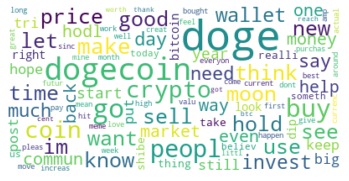

dict_keys(['doge', 'dogecoin', 'go', 'buy', 'peopl', 'crypto', 'coin', 'make', 'sell', 'use', 'time', 'new', 'want', 'price', 'think', 'hold', 'im', 'moon', 'good', 'know', 'let', 'see', 'wallet', 'invest', 'say', 'need', 'much', 'day', 'money', 'market', 'commun', 'help', 'back', 'even', 'one', 'way', 'hodl', 'year', 'start', 'hope', 'keep', 'post', 'tri', 'put', 'big', 'still', 'right', 'look', 'bitcoin', 'dip', 'realli', 'take', 'thing', 'shibe', 'believ', 'us', 'today', 'someth', 'purchas', 'bought', 'week', 'everyon', 'happen', 'hit', 'dont', 'work', 'pleas', 'valu', 'come', 'high', 'mine', 'love', 'sinc', 'long', 'current', 'first', 'month', 'currenc', 'increas', 'best', 'amp', 'feel', 'littl', 'creat', 'well', 'meme', 'mean', 'futur', 'move', 'actual', 'around', 'give', 'great', 'pay', 'thank', 'got', 'worth', 'btc', 'reach', 'cent'])


In [85]:
text = ''.join(processed_df.selftext_processed.fillna(''))

wordcloud = wc.WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print(wordcloud.words_.keys())

## Merging

In [86]:
grouped_df = processed_df.drop(['title','title_processed','created_utc','domain','post_hint','selftext','selftext_processed','author_premium'],axis=1)
grouped_df = grouped_df.groupby(['month','day','hour']).mean()
grouped_df

num_comments  ...  SIA_compound_selftext
month day hour                ...                       
3     2   15        2.500000  ...               0.071507
          16        0.416667  ...               0.067717
          17        8.761905  ...               0.031929
          18        0.937500  ...               0.000000
          19        0.529412  ...               0.000000
...                      ...  ...                    ...
5     4   9         7.000000  ...               0.000000
          17        0.333333  ...               0.000000
          18        1.894737  ...               0.000137
          19        2.571429  ...               0.026218
          20        0.500000  ...               0.000000

[768 rows x 23 columns]

In [87]:
grouped_df = grouped_df.reset_index()
grouped_df

,month,day,hour,num_comments,score,total_awards_received,upvote_ratio,edited,buy_count,hold_count,sell_count,selftext_buy_count,selftext_hold_count,selftext_sell_count,polarity,subjectivity,SIA_neg,SIA_neu,SIA_pos,SIA_compound,polarity_selftext,subjectivity_selftext,SIA_neg_selftext,SIA_neu_selftext,SIA_pos_selftext,SIA_compound_selftext
0,3,2,15,2.500000,1.071429,0.000000,1.000000,0.0,0.071429,0.000000,0.000000,0.035714,0.028571,0.037594,0.039838,0.137110,0.000000,0.830857,0.169143,0.104921,0.002834,0.049263,0.013071,0.096286,0.033429,0.071507
1,3,2,16,0.416667,1.000000,0.000000,1.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.162879,0.013833,0.873667,0.112583,0.122083,0.000000,0.000000,0.005667,0.216417,0.027917,0.067717
2,3,2,17,8.761905,1.047619,0.000000,1.000000,0.0,0.317460,0.000000,0.028571,0.142857,0.000000,0.000000,-0.046967,0.280017,0.134095,0.720714,0.145190,0.076010,-0.001589,0.107159,0.014476,0.202952,0.020714,0.031929
3,3,2,18,0.937500,1.250000,0.000000,1.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005208,0.028646,0.022812,0.887563,0.089625,0.004825,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000
4,3,2,19,0.529412,1.000000,0.000000,1.000000,0.0,0.264706,0.058824,0.039216,0.000000,0.000000,0.000000,0.090705,0.171492,0.000000,0.898118,0.101882,0.205088,0.000000,0.000000,0.000000,0.235294,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,4,9,7.000000,17.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
764,5,4,17,0.333333,19.333333,0.000000,0.980000,0.0,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.125000,0.250000,0.000000,0.787333,0.212667,0.504900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
765,5,4,18,1.894737,17.789474,0.210526,0.988158,0.0,0.203947,0.041353,0.000000,0.000000,0.000000,0.000000,0.089414,0.184111,0.047605,0.799895,0.152500,0.168818,-0.004825,0.011842,0.020079,0.050500,0.008368,0.000137
766,5,4,19,2.571429,18.214286,0.285714,0.995179,0.0,0.208333,0.126488,0.035714,0.011905,0.010714,0.000000,0.019571,0.176850,0.055429,0.821643,0.122946,0.068616,0.010070,0.031942,0.005464,0.094143,0.007536,0.026218


In [88]:
doge_price_df

,Datetime,Open,High,Low,Close,Adj Close,Volume,month,day,hour
111,2021-03-02 15:00:00,0.051079,0.051209,0.050664,0.050819,0.050819,0,3,2,15
112,2021-03-02 16:00:00,0.050810,0.050839,0.049299,0.049299,0.049299,0,3,2,16
113,2021-03-02 17:00:00,0.049332,0.050202,0.049332,0.050093,0.050093,21700352,3,2,17
114,2021-03-02 18:00:00,0.050104,0.050128,0.049720,0.049737,0.049737,0,3,2,18
115,2021-03-02 19:00:00,0.049744,0.049962,0.049420,0.049662,0.049662,0,3,2,19
...,...,...,...,...,...,...,...,...,...,...
1624,2021-05-04 16:00:00,0.528305,0.554466,0.519437,0.554466,0.554466,1587585024,5,4,17
1625,2021-05-04 17:00:00,0.560045,0.581502,0.556832,0.568583,0.568583,2184458240,5,4,18
1626,2021-05-04 18:00:00,0.568217,0.576627,0.540515,0.544642,0.544642,264626176,5,4,19
1627,2021-05-04 19:00:00,0.546201,0.571689,0.546201,0.570399,0.570399,1748258816,5,4,20


In [89]:
merge_df = pd.merge(grouped_df,doge_price_df.drop('Datetime',axis=1), how='left', on=['month','day','hour'])
merge_df

,month,day,hour,num_comments,score,total_awards_received,upvote_ratio,edited,buy_count,hold_count,sell_count,selftext_buy_count,selftext_hold_count,selftext_sell_count,polarity,subjectivity,SIA_neg,SIA_neu,SIA_pos,SIA_compound,polarity_selftext,subjectivity_selftext,SIA_neg_selftext,SIA_neu_selftext,SIA_pos_selftext,SIA_compound_selftext,Open,High,Low,Close,Adj Close,Volume
0,3,2,15,2.500000,1.071429,0.000000,1.000000,0.0,0.071429,0.000000,0.000000,0.035714,0.028571,0.037594,0.039838,0.137110,0.000000,0.830857,0.169143,0.104921,0.002834,0.049263,0.013071,0.096286,0.033429,0.071507,0.051079,0.051209,0.050664,0.050819,0.050819,0
1,3,2,16,0.416667,1.000000,0.000000,1.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.162879,0.013833,0.873667,0.112583,0.122083,0.000000,0.000000,0.005667,0.216417,0.027917,0.067717,0.050810,0.050839,0.049299,0.049299,0.049299,0
2,3,2,17,8.761905,1.047619,0.000000,1.000000,0.0,0.317460,0.000000,0.028571,0.142857,0.000000,0.000000,-0.046967,0.280017,0.134095,0.720714,0.145190,0.076010,-0.001589,0.107159,0.014476,0.202952,0.020714,0.031929,0.049332,0.050202,0.049332,0.050093,0.050093,21700352
3,3,2,18,0.937500,1.250000,0.000000,1.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005208,0.028646,0.022812,0.887563,0.089625,0.004825,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0.050104,0.050128,0.049720,0.049737,0.049737,0
4,3,2,19,0.529412,1.000000,0.000000,1.000000,0.0,0.264706,0.058824,0.039216,0.000000,0.000000,0.000000,0.090705,0.171492,0.000000,0.898118,0.101882,0.205088,0.000000,0.000000,0.000000,0.235294,0.000000,0.000000,0.049744,0.049962,0.049420,0.049662,0.049662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,4,9,7.000000,17.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.466557,0.493179,0.461531,0.483789,0.483789,2779873280
764,5,4,17,0.333333,19.333333,0.000000,0.980000,0.0,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.125000,0.250000,0.000000,0.787333,0.212667,0.504900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.528305,0.554466,0.519437,0.554466,0.554466,1587585024
765,5,4,18,1.894737,17.789474,0.210526,0.988158,0.0,0.203947,0.041353,0.000000,0.000000,0.000000,0.000000,0.089414,0.184111,0.047605,0.799895,0.152500,0.168818,-0.004825,0.011842,0.020079,0.050500,0.008368,0.000137,0.560045,0.581502,0.556832,0.568583,0.568583,2184458240
766,5,4,19,2.571429,18.214286,0.285714,0.995179,0.0,0.208333,0.126488,0.035714,0.011905,0.010714,0.000000,0.019571,0.176850,0.055429,0.821643,0.122946,0.068616,0.010070,0.031942,0.005464,0.094143,0.007536,0.026218,0.568217,0.576627,0.540515,0.544642,0.544642,264626176


Align features one hour before price

In [90]:
for col in merge_df.columns:
  if col not in ['month','day','hour','Open','High','Low','Close','Adj Close','Volume']:
    merge_df[col] = np.append(merge_df[col][1::].values,np.nan)

Normalizing

In [91]:
merge_df['num_comments']=merge_df['num_comments']/max(merge_df['num_comments'])
merge_df['score']=merge_df['score']/max(merge_df['score'])
merge_df['total_awards_received']=merge_df['total_awards_received']/max(merge_df['total_awards_received'])
merge_df['Volume']=merge_df['Volume']/max(merge_df['Volume'])

#Use MinMaxScaler for better results

Convert mean of binary features to binary

In [92]:
merge_df['edited'] = merge_df['edited'].apply(lambda x : 1.0 if x>=0.5 else 0.0)

#Preparation

Construction of target variable (label)

In [93]:
merge_df['target'] = ((merge_df['Close'] - merge_df['Open'])/merge_df['Close'])*5
#merge_df['target'] = merge_df['target'].apply(lambda x: 1.0 if x>0 else 0.0)
merge_df = merge_df.dropna(axis=0).copy()

Features to keep

In [94]:
keep_columns = [
                'num_comments',
                'score',
                'total_awards_received',
                'upvote_ratio',
                'edited',
                'polarity',
                'subjectivity',
                'SIA_neg',
                'SIA_neu',
                'SIA_pos',
                'SIA_compound',
                'polarity_selftext',
                'subjectivity_selftext',
                'SIA_neg_selftext',
                'SIA_neu_selftext',
                'SIA_pos_selftext',
                'SIA_compound_selftext',
                'target',
                'buy_count',
                'hold_count',
                'sell_count',
                'selftext_buy_count',
                'selftext_hold_count',
                'selftext_sell_count'
                ]
df = merge_df[keep_columns]

Correlation heatmap

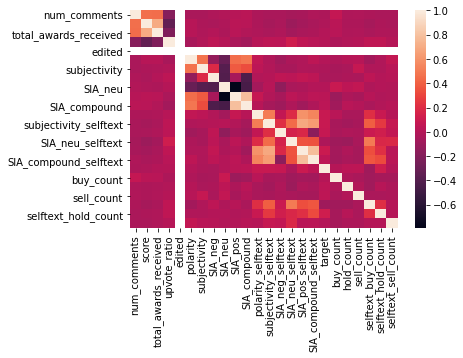

In [95]:
sns.heatmap(df.corr())
plt.show()

#Training

Data splitting

In [96]:
x = np.array(df.drop(['target'],1))
y = np.array(df['target'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

Model compile

In [97]:
model = tf.keras.Sequential([
  keras.layers.Dense(6),
  keras.layers.Dense(128),
  keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer="sgd",loss='mean_absolute_error')

Training

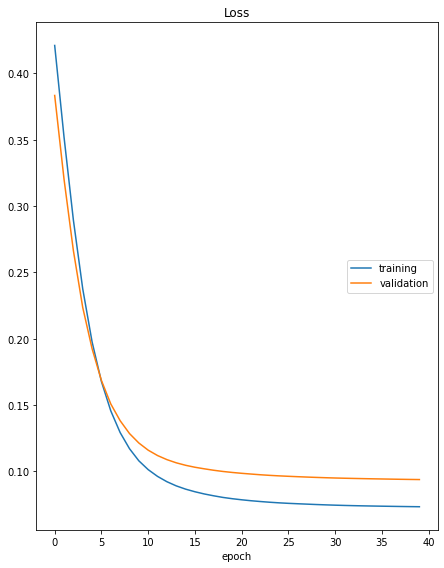

Loss
	training         	 (min:    0.073, max:    0.421, cur:    0.073)
	validation       	 (min:    0.094, max:    0.383, cur:    0.094)


In [98]:
history = model.fit(x_train,y_train,
                    epochs=40,
                    callbacks=[PlotLossesKeras()],
                    validation_data=(x_val, y_val),
                    verbose=0)

Evaluating and Testing

In [99]:
model.evaluate(x_test,y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0742


0.07418277859687805

In [100]:
predictions = model.predict(x_test)

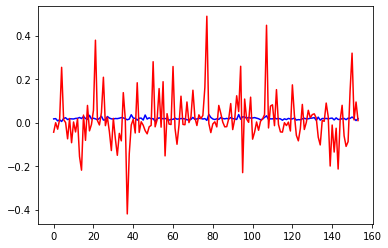

In [101]:
plt.plot(predictions,c='b')
plt.plot(y_test,c='r')
plt.show()